In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
from dataset import airportnet_data
y = pokec_data.SmallPokecDataFrame().get_grouped_col()

Using existing file soc-pokec-profiles.txt.gz
Using existing file soc-pokec-relationships.txt.gz


In [4]:
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '//data/sg/ashutiwa/final_results/small_pokec/'
! ls /data/sg/ashutiwa/final_results/small_pokec/
DIRS = ['data_one/', 'data_two/', 'data_three/', 'data_four/']
DATASET = 'small_pokec'
M = ["GCN_baseline", "GCN_r2v", "GCN_baseline_crosswalk", "GCN_r2v_crosswalk", 
     "GAT_baseline","GAT_r2v", "GAT_baseline_crosswalk", "GAT_r2v_crosswalk"]
k=5

data_four  data_one  data_three  data_two


# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)
def get_roc_score_(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    from sklearn.preprocessing import MinMaxScaler
    y_pred = MinMaxScaler().fit_transform([y_pred])[0]
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)

In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

# GCN ( baseline)

In [7]:
model = "GCN_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gcn_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269231/269231 [00:00<00:00, 378806.53it/s]


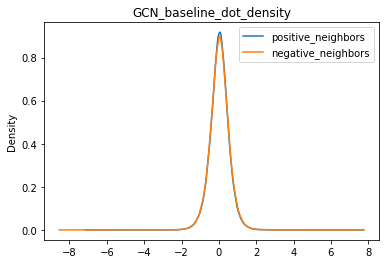

In [8]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [9]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 272.79it/s]


((1346155, 2), 3.5878285396295264e-06, 0.500029453621304, 0.06929508784128316)

# GCN ( baseline + crosswalk)

In [10]:
model = "GCN_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269231/269231 [00:00<00:00, 404541.62it/s]


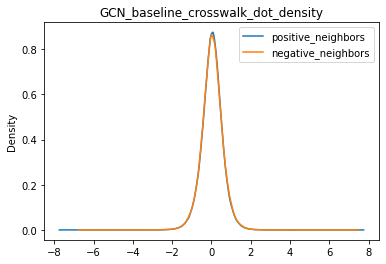

In [11]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [12]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:01<00:00, 132.05it/s]


((1346155, 2), 3.545839731448401e-06, 0.500610660124868, 0.06885704665693124)

# GCN ( r2v)

In [13]:
model = "GCN_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET  + '_gcn_r2v_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269231/269231 [00:00<00:00, 393123.37it/s]


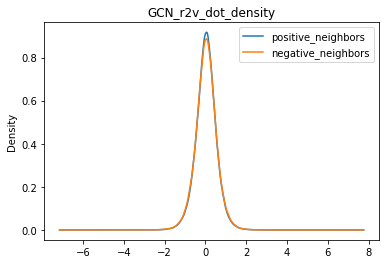

In [14]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [15]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 258.90it/s]


((1346155, 2), 3.5475085510983796e-06, 0.5012175616065058, 0.06860201433297612)

# GCN ( r2v + crosswalk)

In [16]:
model = "GCN_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_r2v_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269231/269231 [00:00<00:00, 398513.09it/s]


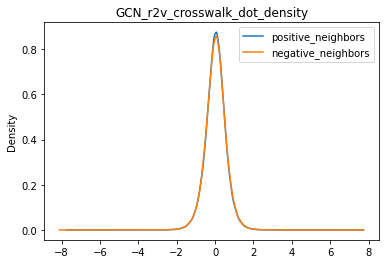

In [17]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [18]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 285.01it/s]


((1346155, 2), 3.556583671602648e-06, 0.49931666075645964, 0.06900999764572344)

# GAT ( baseline)

In [19]:
model = "GAT_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269231/269231 [00:00<00:00, 393103.94it/s]


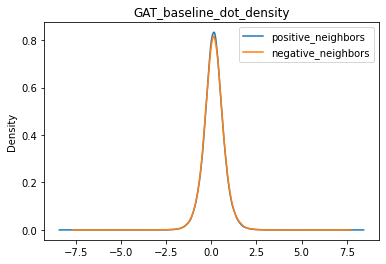

In [20]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [21]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 136.80it/s]


((1346155, 2), 3.52743078074719e-06, 0.49880535959656813, 0.06826791914346783)

# GAT ( baseline + crosswalk)

In [22]:
model = "GAT_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269231/269231 [00:00<00:00, 398822.31it/s]


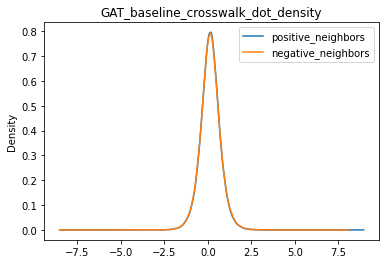

In [23]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [24]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 284.83it/s]


((1346155, 2), 3.54013336045438e-06, 0.4995687920933363, 0.06819595334372355)

# GAT ( r2v)

In [25]:
model = "GAT_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_r2v_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269231/269231 [00:00<00:00, 392764.44it/s]


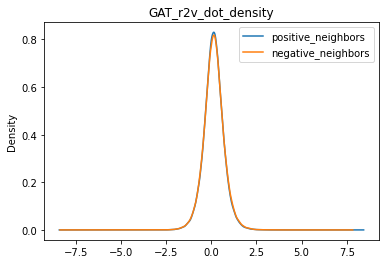

In [26]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [27]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:01<00:00, 99.64it/s]


((1346155, 2), 3.5693639190342495e-06, 0.4980439840194166, 0.06872790782886158)

# GAT ( r2v + crosswalk)

In [28]:
model = "GAT_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_r2v_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((269231, 128), (269231, 128), (269231, 128))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269231/269231 [00:00<00:00, 396866.31it/s]


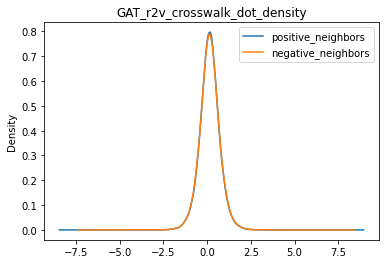

In [29]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [30]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 156.70it/s]


((1346155, 2), 3.5506187760364426e-06, 0.4991305248273459, 0.06827685583916712)

# plot statistical parity scores

# gini sp scores

GCN_baseline 0.06929508784128316
GCN_baseline_crosswalk 0.06885704665693124
GCN_r2v 0.06860201433297612
GCN_r2v_crosswalk 0.06900999764572344
GAT_baseline 0.06826791914346783
GAT_baseline_crosswalk 0.06819595334372355
GAT_r2v 0.06872790782886158
GAT_r2v_crosswalk 0.06827685583916712


Text(0.5, 1.0, 'gini statistical parity scores')

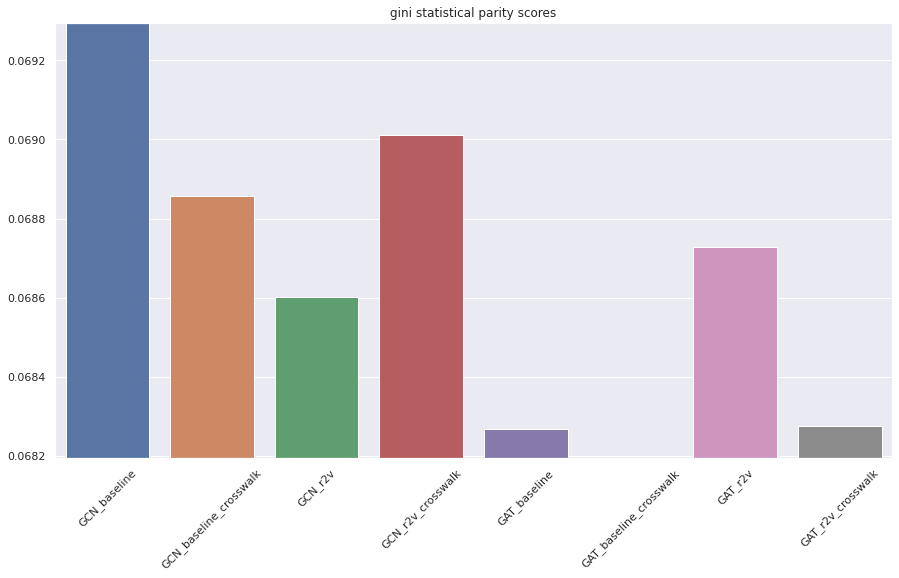

In [31]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()), max(gini_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

GCN_baseline 3.5878285396295264e-06
GCN_baseline_crosswalk 3.545839731448401e-06
GCN_r2v 3.5475085510983796e-06
GCN_r2v_crosswalk 3.556583671602648e-06
GAT_baseline 3.52743078074719e-06
GAT_baseline_crosswalk 3.54013336045438e-06
GAT_r2v 3.5693639190342495e-06
GAT_r2v_crosswalk 3.5506187760364426e-06


Text(0.5, 1.0, 'statistical parity scores')

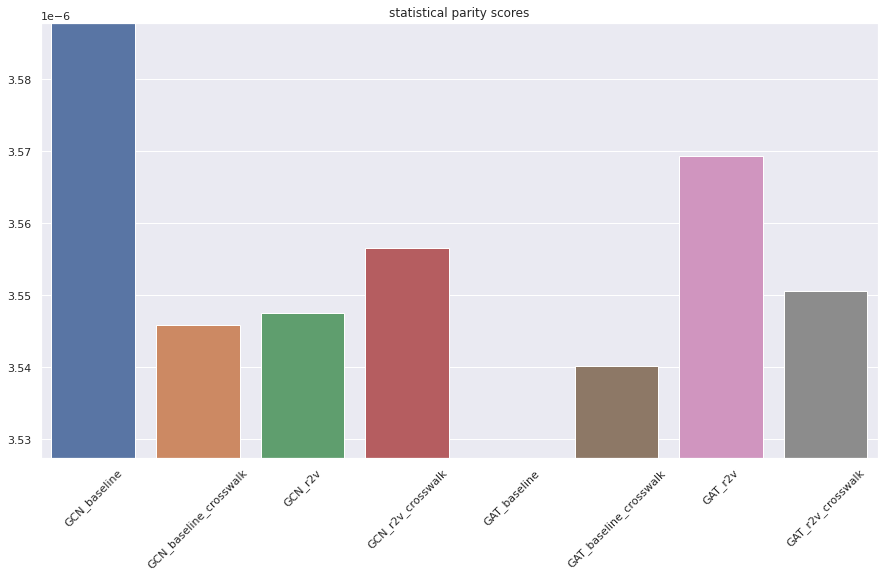

In [32]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()), max(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

GCN_baseline 0.500029453621304
GCN_baseline_crosswalk 0.500610660124868
GCN_r2v 0.5012175616065058
GCN_r2v_crosswalk 0.49931666075645964
GAT_baseline 0.49880535959656813
GAT_baseline_crosswalk 0.4995687920933363
GAT_r2v 0.4980439840194166
GAT_r2v_crosswalk 0.4991305248273459


Text(0.5, 1.0, 'roc scores')

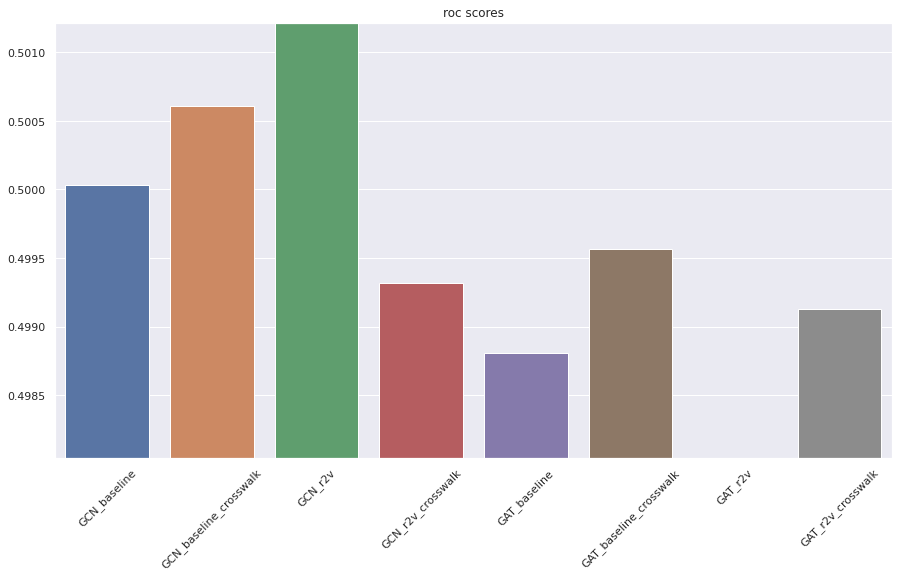

In [33]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()), max(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [34]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m][:, :128]
        edges = snakemake_utils.return_new_graph(A, k, )
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:01<00:00, 128.73it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 174.39it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 191.98it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 177.44it/s]


Text(0.5, 1.0, 'gini scores vs # nn')

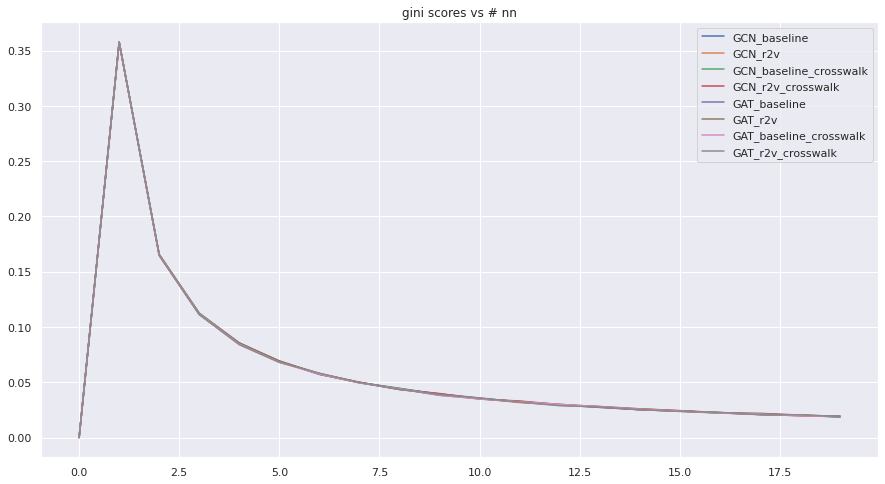

In [35]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

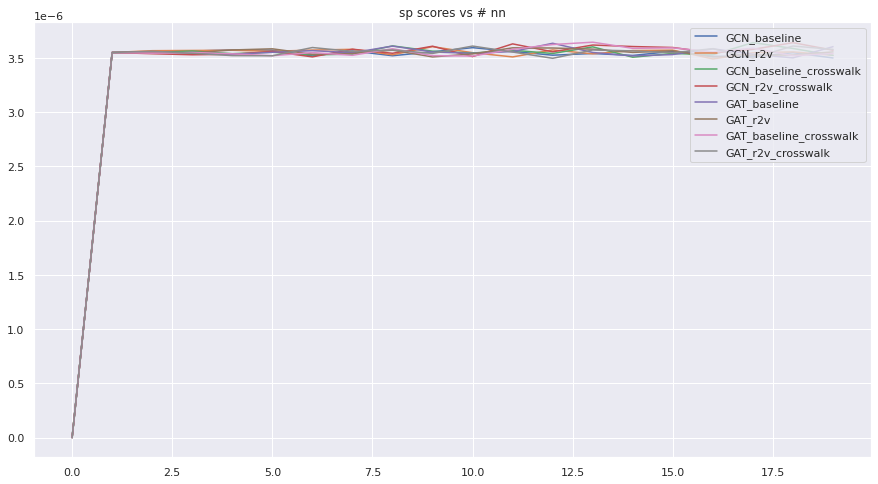

In [36]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [37]:
MODEL_NAME_2_FILE = {
    "GCN_baseline": "_gcn_node2vec_embs.npy",
    "GCN_baseline_crosswalk": "_crosswalk_gcn_node2vec_embs.npy",
    "GCN_r2v": "_gcn_r2v_node2vec_embs.npy",
    "GCN_r2v_crosswalk": '_crosswalk_gcn_r2v_node2vec_embs.npy',
    "GAT_baseline": '_gat_node2vec_embs.npy',
    "GAT_baseline_crosswalk": "_crosswalk_gat_node2vec_embs.npy",
    "GAT_r2v": "_gat_r2v_node2vec_embs.npy",
    "GAT_r2v_crosswalk": "_crosswalk_gat_r2v_node2vec_embs.npy"
}
def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        emb = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
        dot = pd.DataFrame({
            "positive_dot": np.array([np.dot(A[i], P[i]) for i in range(A.shape[0])]),
            "negative_dot": np.array([np.dot(A[i], N[i]) for i in range(A.shape[0])])
        })
        scores[idx] = get_roc_score(dot)
    return np.mean(scores)


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        emb = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
        edges = snakemake_utils.return_new_graph(A, K)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return np.mean(scores), np.mean(scores_gini)

GCN_baseline 0.5002629339156233
GCN_baseline_crosswalk 0.5004800869047792
GCN_r2v 0.5009311973779058
GCN_r2v_crosswalk 0.5001564681800035
GAT_baseline 0.498816776578935
GAT_baseline_crosswalk 0.4984584264512293
GAT_r2v 0.4985565965980905
GAT_r2v_crosswalk 0.4984510540820207


Text(0.5, 1.0, 'roc scores')

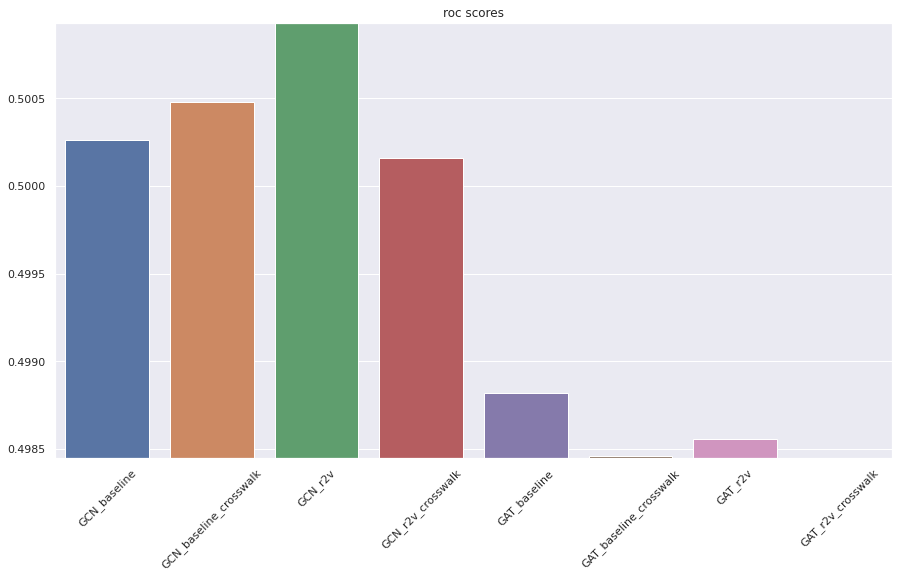

In [38]:

roc_score = {m: roc_scores(m) for m in MODEL_NAME_2_FILE}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()), max(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 277.79it/s]


GCN_baseline 3.5617144447529894e-06
GCN_baseline_crosswalk 3.55219967930941e-06
GCN_r2v 3.5759877005344765e-06
GCN_r2v_crosswalk 3.532593273999905e-06
GAT_baseline 3.5537181385662973e-06
GAT_baseline_crosswalk 3.5559341075571184e-06
GAT_r2v 3.539564729000157e-06
GAT_r2v_crosswalk 3.537082532431347e-06


Text(0.5, 1.0, 'statistical parity scores')

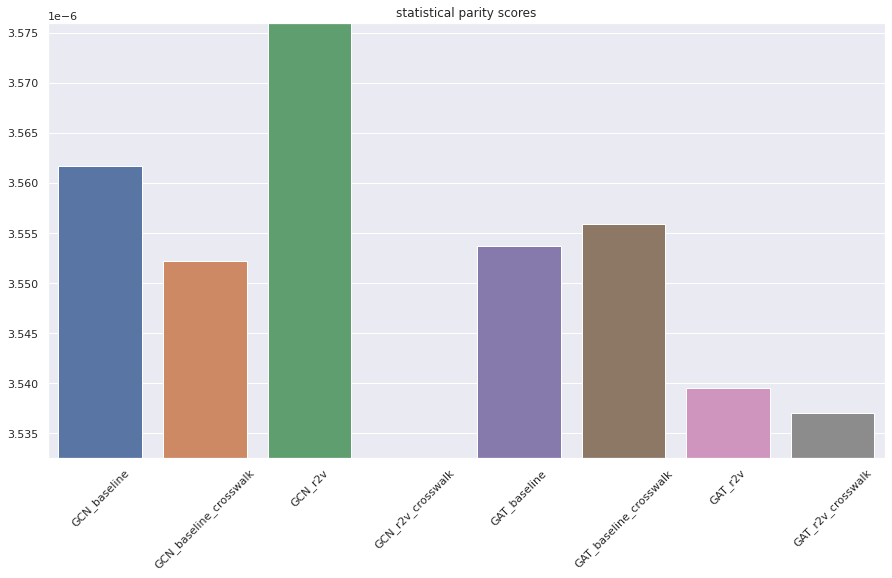

In [39]:

temp = {m: statisticalp_scores(m) for m in MODEL_NAME_2_FILE}

sp_score = {m: v[0] for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()), max(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

GCN_baseline 0.06887975852495665
GCN_baseline_crosswalk 0.06893669875579159
GCN_r2v 0.06930278917579402
GCN_r2v_crosswalk 0.06831854523684282
GAT_baseline 0.06858857502904572
GAT_baseline_crosswalk 0.06867811908982326
GAT_r2v 0.06826536213377499
GAT_r2v_crosswalk 0.06841019836991362


Text(0.5, 1.0, 'gini statistical parity scores')

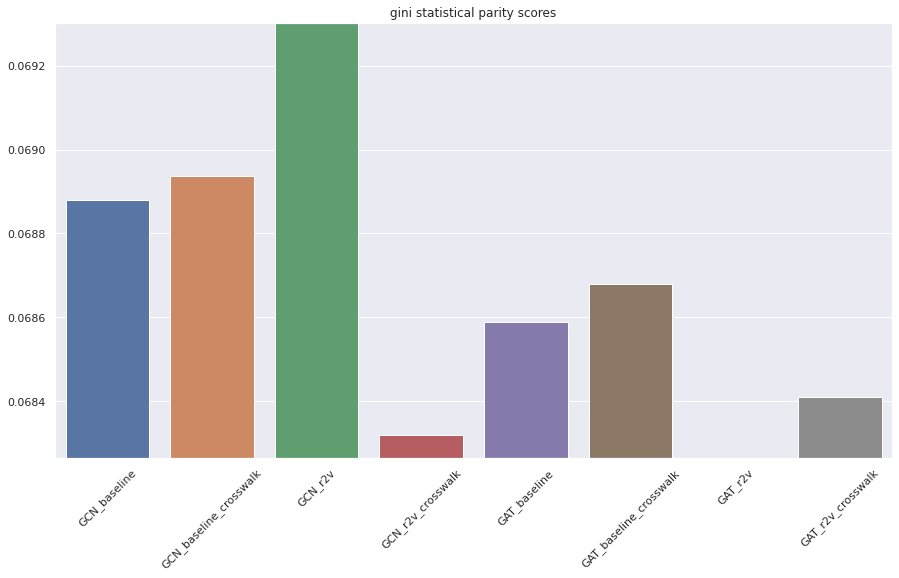

In [40]:
gini_score = {m: v[1] for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()), max(gini_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")